In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

2023-10-03 21:02:04.783115: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-03 21:02:07.549514: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-03 21:02:07.570620: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-03 21:02:13.177271: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
train_data = pd.read_csv('../datasets/horse_health/train.csv')
test_data = pd.read_csv('../datasets/horse_health/test.csv')
origin = pd.read_csv('../datasets/horse_health/horse.csv')
sample_submission = pd.read_csv('../datasets/horse_health/sample_submission.csv')

In [5]:
train_data["is_generated"] = 1
test_data["is_generated"] = 1
origin["is_generated"] = 0

train_data.drop('id', axis=1, inplace=True)
test_data.drop('id', axis=1, inplace=True)

total = pd.concat([train_data, origin], ignore_index=True)
total.drop_duplicates(inplace=True)

target = 'outcome'
total[target] = total[target].apply(lambda x: 1 if x == 'euthanized' else 0 if x == 'died' else 2)


KeyError: "['id'] not found in axis"

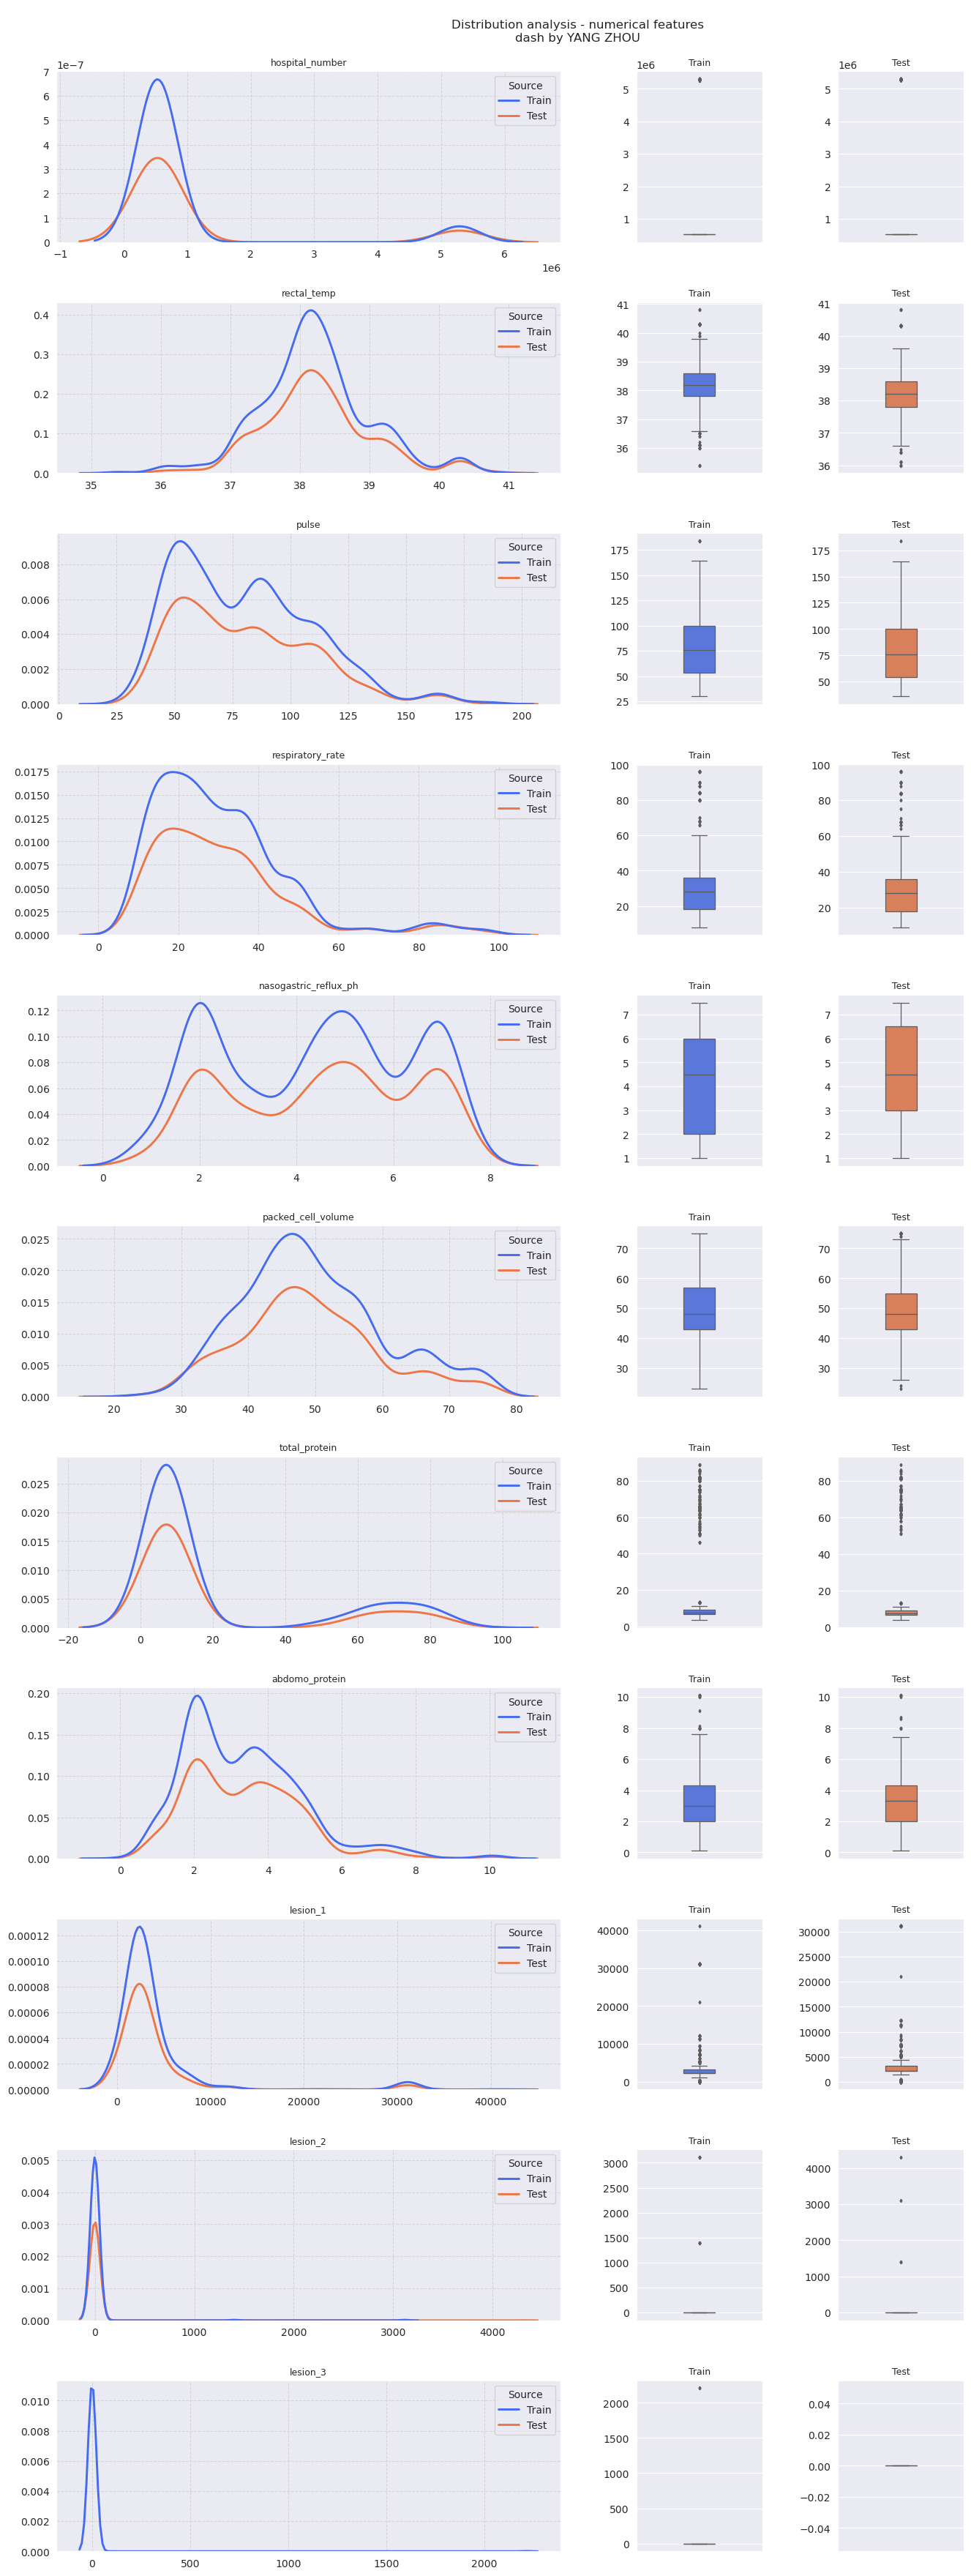

In [70]:
num = train_data.select_dtypes(include=['int64','float64']).columns

df = pd.concat([train_data[num].assign(Source = 'Train'), test_data[num].assign(Source = 'Test')], ignore_index = True)

# Use of more advanced artistic matplotlib interface (see the axes)
fig, axes = plt.subplots(len(num), 3 ,figsize = (16, len(num) * 4), gridspec_kw = {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.80, 0.20, 0.20]})

for i,col in enumerate(num):
    ax = axes[i,0]
    sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', palette=['#456cf0', '#ed7647'], linewidth = 2.1, warn_singular=False, ax = ax) # Use of seaborn with artistic interface
    ax.set_title(f"\n{col}",fontsize = 9)
    ax.grid(visible=True, which = 'both', linestyle = '--', color='lightgrey', linewidth = 0.75)
    ax.set(xlabel = '', ylabel = '')

    ax = axes[i,1]
    sns.boxplot(data = df.loc[df.Source == 'Train', [col]], y = col, width = 0.25, linewidth = 0.90, fliersize= 2.25, color = '#456cf0', ax = ax)
    ax.set(xlabel = '', ylabel = '')
    ax.set_title("Train", fontsize = 9)

    ax = axes[i,2]
    sns.boxplot(data = df.loc[df.Source == 'Test', [col]], y = col, width = 0.25, linewidth = 0.90, fliersize= 2.25, color = '#ed7647', ax = ax)
    ax.set(xlabel = '', ylabel = '')
    ax.set_title("Test", fontsize = 9)

plt.suptitle(f'\nDistribution analysis - numerical features\ndash by YANG ZHOU\n',fontsize = 12, y = 0.9, x = 0.57)
plt.show()

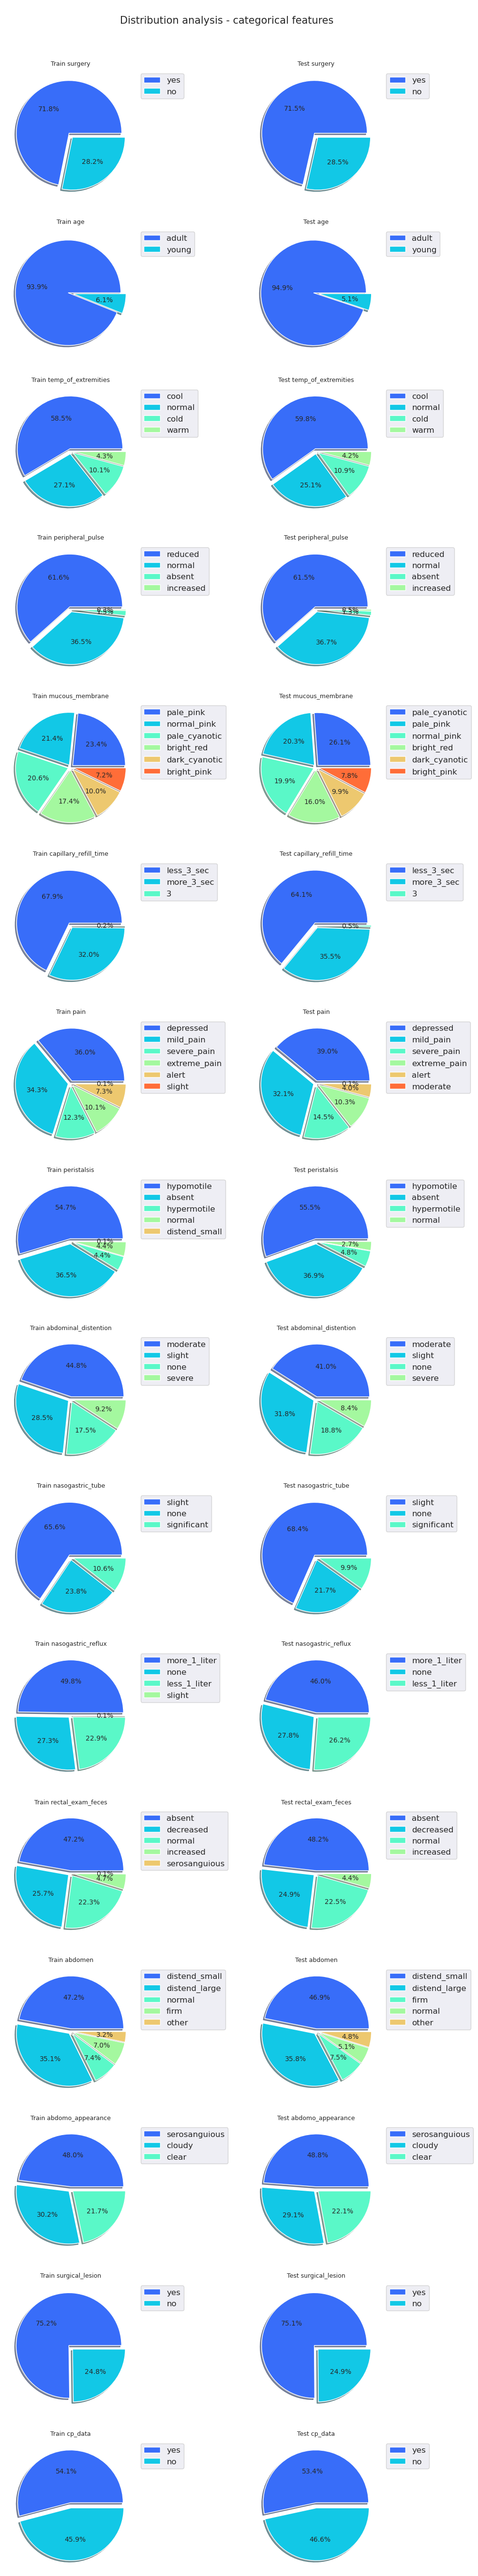

In [71]:
sns.set_palette('rainbow')

num = train_data.drop(columns='outcome').select_dtypes(include=['object']).columns

df = pd.concat([train_data[num].assign(Source = 'train'), 
                test_data[num].assign(Source = 'test')], 
               axis=0, ignore_index = True)

fig, axes = plt.subplots(len(num), 2 ,figsize = (12, len(num) * 4.2))

for i,col in enumerate(num):
    train_dist = df.loc[df.Source == 'train', [col]].value_counts()
    test_dist = df.loc[df.Source == 'test', [col]].value_counts()
    
    ax = axes[i,0]
    ax.pie(train_dist, shadow=True, explode=[.05]*len(train_dist), autopct='%.1f%%')
    ax.legend([category[0] for category in train_dist.index], loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    ax.set(xlabel = '', ylabel = '')
    ax.set_title(f'Train {col}',fontsize = 9)

    ax = axes[i,1]
    ax.pie(test_dist, shadow=True, explode=[.05]*len(test_dist), autopct='%.1f%%')
    ax.legend([category[0] for category in test_dist.index], loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    ax.set(xlabel = '', ylabel = '')
    ax.set_title(f'Test {col}',fontsize = 9)


plt.suptitle(f"\nDistribution analysis - categorical features\n",fontsize = 15, y = 0.9, x = 0.57)
plt.show()

In [72]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder,StandardScaler, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

def transform(df, num, cat):
    numerical_pipeline = make_pipeline(
        QuantileTransformer(output_distribution='normal'),
        StandardScaler()
    )

    categorical_pipeline = make_pipeline(
        OneHotEncoder(handle_unknown='ignore')
    )

    transformer = ColumnTransformer([
        ('numerical', numerical_pipeline, num),
        ('categorical', categorical_pipeline, cat)
    ])

def preprocessing(df, le_cols, ohe_cols):
    le = LabelEncoder()
    ohe = OneHotEncoder(handle_unknown='ignore')
    
    

In [73]:
def transform_live_death_binary(df, cols):
    for col in cols:
        if df[col].dtype in ['int64', 'float64']:
            continue
        df[col] = df[col].apply(lambda x: 1 if x == 'euthanized' else 0 if x == 'lived' else 2)
        df[col] = df[col].astype('int64')
    return df

def transform_age(df, cols):
    for col in cols:
        df[col] = df[col].apply(lambda x: 1 if x == 'adult' else 0)
        df[col] = df[col].astype('int64')
    return df

def transform_y_n(df, col):
    df[col] = df[col].apply(lambda x: 1 if x == 'yes' else 0)
    return df

def treat_na(df, cols, filler_val):
    for col in cols:
        df[col] = df[col].fillna(filler_val)
    return df

def get_corr_mat(df, cols, target, all=True, top_n=10):
    corr = df[cols].corr()
    
    if all:
        return corr[target]
    
    if top_n:
        return corr.nlargest(top_n, target)[target]

def get_num_cols(df):
    return df.select_dtypes(include=np.number).columns

def get_cat_cols(df):
    return df.select_dtypes(exclude=np.number).columns

In [75]:
transform_live_death_binary(train_data, ['outcome'])
transform_age(train_data, ['age'])
transform_age(test_data, ['age'])
transform_y_n(train_data, 'surgery')
transform_y_n(test_data, 'surgery')

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,0,1,534053,38.6,40.0,20.0,normal,normal,normal_pink,less_3_sec,...,distend_small,42.0,7.5,clear,2.3,no,0,0,0,no
1,1,1,528469,38.2,112.0,48.0,cool,reduced,bright_pink,more_3_sec,...,distend_small,44.0,6.0,serosanguious,2.6,no,2208,0,0,yes
2,1,1,528178,37.7,66.0,12.0,cool,normal,bright_red,less_3_sec,...,distend_small,31.5,6.0,cloudy,1.6,yes,2205,0,0,yes
3,0,1,534784,37.1,88.0,20.0,cool,reduced,pale_cyanotic,less_3_sec,...,distend_large,75.0,81.0,NaN,1.0,yes,1400,0,0,no
4,1,1,529840,38.3,50.0,12.0,NaN,normal,bright_pink,less_3_sec,...,distend_small,37.0,6.8,cloudy,2.6,yes,2208,0,0,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,0,1,529461,40.3,114.0,36.0,cool,reduced,normal_pink,more_3_sec,...,distend_large,57.0,8.1,serosanguious,4.5,yes,3205,0,0,yes
820,1,1,535338,37.2,100.0,20.0,cool,reduced,pale_cyanotic,more_3_sec,...,distend_small,50.0,66.0,serosanguious,2.0,yes,2209,0,0,no
821,1,1,529640,39.2,132.0,12.0,cool,reduced,dark_cyanotic,more_3_sec,...,NaN,53.0,7.6,serosanguious,4.5,yes,2205,0,0,no
822,0,1,5287179,38.3,54.0,66.0,normal,normal,normal_pink,less_3_sec,...,NaN,49.0,8.6,clear,5.0,no,3111,0,0,yes


In [ ]:
get_corr_mat(train_data, get_num_cols(train_data), 'outcome')

In [ ]:
import json

num_cols = get_num_cols(train_data)
cat_cols = get_cat_cols(train_data)
unique_vals = {col: list(train_data[col].unique()) for col in cat_cols}

json.dump(unique_vals, open('unique_vals.json', 'w'))

In [76]:
missing_values = combined_data.isnull().sum()
print(missing_values[missing_values > 0])

temp_of_extremities       74
peripheral_pulse         107
mucous_membrane           34
capillary_refill_time     12
pain                      73
peristalsis               39
abdominal_distention      45
nasogastric_tube         144
nasogastric_reflux        35
rectal_exam_feces        315
abdomen                  367
abdomo_appearance         79
outcome                  824
dtype: int64


In [ ]:
combined_data['temp_of_extremities'] = combined_data['temp_of_extremities'].fillna('normal')
combined_data['peripheral_pulse'] = combined_data['peripheral_pulse'].fillna('normal')
combined_data['mucous_membrane'] = combined_data['mucous_membrane'].fillna('normal')
combined_data['capillary_refill_time'] = combined_data['capillary_refill_time'].fillna('less_3_sec')
combined_data['pain'] = combined_data['pain'].fillna('alert')
combined_data['abdominal_distention'] = combined_data['abdominal_distention'].fillna('slight')
combined_data['nasogastric_tube'] = combined_data['nasogastric_tube'].fillna('slight')
combined_data['nasogastric_reflux'] = combined_data['nasogastric_reflux'].fillna('none')
combined_data['rectal_exam_feces'] = combined_data['rectal_exam_feces'].fillna('absent')
combined_data['abdomen'] = combined_data['abdomen'].fillna('distend_large')
combined_data['abdomo_appearance'] = combined_data['abdomo_appearance'].fillna('cloudy')
combined_data['abdomo_protein'] = combined_data['abdomo_protein'].fillna('2.0')

In [ ]:
uniq = train_data[cat_cols].nunique()
print(uniq)

In [ ]:
sns.histplot(x='age', y='outcome', data=train_data)

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(25, 25))
px, py = 0, 0
for col in cat_cols:
    sns.histplot(x=col, y=train_data['outcome'], data=train_data, ax=axes[py, px])
    px += 1
    if px == 5:
        px = 0
        py += 1
        